In [615]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.text import FreqDistVisualizer
import nltk
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import operator
import seaborn

In [116]:
#import DataFrame from crawler
data = pd.read_pickle("full_data.pkl")

Build text classification model

Some further pre-processing

In [117]:
#set seed for reproduability
np.random.seed(5)

In [118]:
#make all text lowercase
data['Text'] = [entry.lower() for entry in data['Text']]

In [120]:
#load vectorizer
tfidf_vec = TfidfVectorizer(max_features=2000, stop_words='english')

In [121]:
#split into train and test data (small amount of test to make training data more robust)
xtrain, xval, ytrain, yval = train_test_split(data['Text'], data['Bias'], test_size=0.15, random_state=1000)

In [510]:
#create features
xtrain_tfidf = tfidf_vec.fit_transform(xtrain)
xval_tfidf = tfidf_vec.transform(xval)

In [123]:
print(tfidf_vec.vocabulary_)

{'facing': 664, 'pornography': 1351, 'charges': 327, 'florida': 713, 'latest': 992, 'nationwide': 1185, 'book': 245, 'write': 1984, 'race': 1439, 'gender': 754, 'reporter': 1500, 'year': 1992, 'publication': 1427, 'author': 188, 'george': 757, 'johnson': 935, 'met': 1130, 'account': 44, 'black': 234, 'boy': 249, 'best': 221, '2020': 17, 'new': 1199, 'york': 1995, 'chicago': 330, 'public': 1426, 'attacks': 175, 'weeks': 1946, 'ago': 90, 'told': 1823, 'near': 1190, 'beginning': 213, '2021': 18, 'school': 1580, 'teaching': 1785, 'certain': 312, 'related': 1482, 'board': 241, 'meetings': 1118, 'panic': 1281, 'adults': 74, 'missouri': 1152, 'pennsylvania': 1307, 'texas': 1799, 'subject': 1739, 'county': 446, 'member': 1119, 'accusing': 50, 'rise': 1546, 'children': 333, 'young': 1996, 'adult': 73, 'members': 1120, 'far': 679, 'right': 1543, 'groups': 790, 'politicians': 1342, 'allegations': 102, 'books': 246, 'don': 565, 'like': 1033, 'targeted': 1779, 'accusations': 48, 'won': 1968, 'wide'

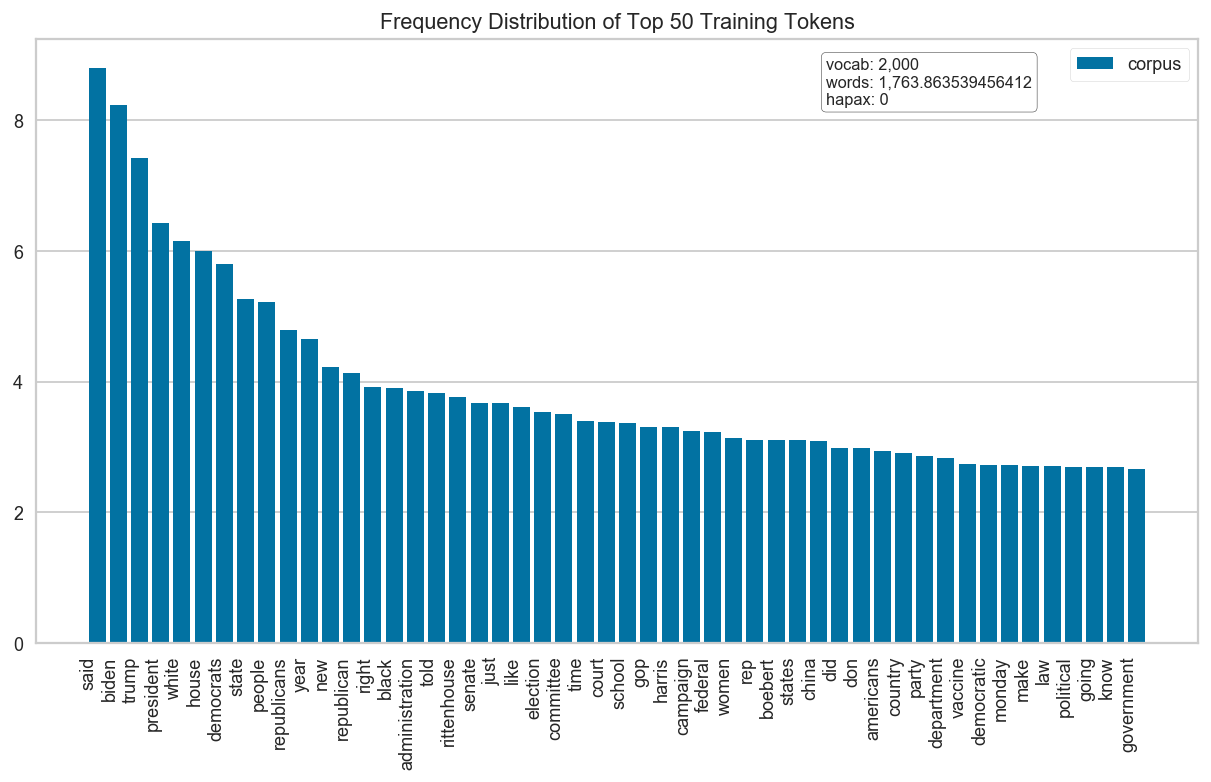

In [513]:
#frequency distribution of tfidf vectorised words minus stopwords
features = tfidf_vec.get_feature_names()

plt.rcParams['figure.dpi'] = 130

visualizer_train = FreqDistVisualizer(features=features, orient='v', size=(1500, 800), title = "Frequency Distribution of Top 50 Training Tokens")
visualizer_train.fit(xtrain_tfidf)
visualizer_train.show()


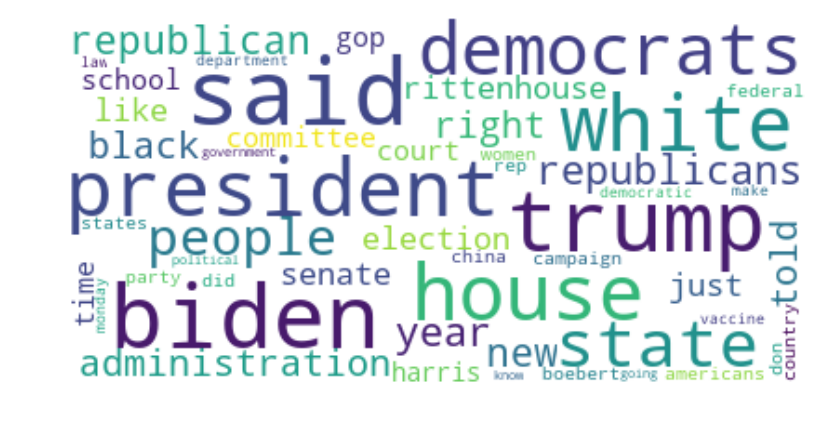

In [796]:
#Build list of word freq for word cloud

sums = xtrain_tfidf.sum(axis=0)

word_count = []
for col, term in enumerate(features):
    word_count.append( (term, sums[0,col] ))

#convert list to DF to sort
ranking = pd.DataFrame(word_count, columns=['Term','Rank'])
word_count = ranking.sort_values('Rank', ascending=False)

#loop through DF to build dictionary
word_dict = {}
for i in range(0,50):
    x = word_count.iloc[i][0]
    y = word_count.iloc[i][1]
    word_dict[x] = y

#build word cloud
cloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate_from_frequencies(word_dict)

#plot word cloud
plt.rcParams['figure.dpi'] = 120

# Display the generated image:
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Build support vector machine (SVM) classifier to classify new text as Left-wing or Right-wing bias

In [417]:
#build support vector machine (SVM) classifier
#SVM = svm.SVC(C=1.0, kernel='linear')
SVM = svm.SVC(C=1, kernel='linear')

In [418]:
#fit the training dataset on the classifier
SVM.fit(xtrain_tfidf,ytrain)

SVC(C=1, kernel='linear')

Test on train data

In [419]:
#run SVM ML model against train data 
SVM_pred_train = SVM.predict(xtrain_tfidf)

In [420]:
#print accuracy of SVM ML model on train data
print("SVM accuracy score on train data:",accuracy_score(SVM_pred_train , ytrain)*100)

SVM accuracy score on train data: 99.04306220095694


In [421]:
conf_mat_train = confusion_matrix(SVM_pred_train , ytrain)

conf_mat_train_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_train, display_labels=['Left-wing', 'Right-wing'])

plt.rcParams['figure.dpi'] = 80
conf_mat_train_disp.plot(cmap = 'Blues')
plt.grid(False)
plt.title('Train Data Confusion Matrix', fontsize=12)
plt.show()

Test on test data

In [422]:
#run SVM ML model against test data 
SVM_pred = SVM.predict(xval_tfidf)

In [423]:
#print accuracy of SVM ML model on test data
print("SVM accuracy score on test data:",accuracy_score(SVM_pred, yval)*100)

SVM accuracy score on test data: 86.8421052631579


In [424]:
conf_mat = confusion_matrix(SVM_pred, yval)

conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['Left-wing', 'Right-wing'])

plt.rcParams['figure.dpi'] = 80
conf_mat_disp.plot(cmap = 'Blues')
plt.grid(False)
plt.title('Test Data Confusion Matrix', fontsize=12)
plt.show()

Build input text vectorizer that classifies bias

In [728]:
#enter input text
input_text = str(input("input text: "))

input text: Trump is a racist


In [723]:
#create function to determine bias

def bias(input):
    #make input text lowercase
    input = input.lower()

    #convert input text to raw text
    input=[input]

    #vectorize input text
    input_text_tfidf = tfidf_vec.transform(input)

    bias = SVM.predict(input_text_tfidf)[0]

    #predict text bias
    #return("This article has a " + bias + " bias.")
    return(bias)

In [729]:
bias(input_text)

'Left-wing'

Build sentiment analysis

First build sentiment analysis on current data for EDA

In [ ]:
#download sentiment engine and wordlist
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

In [441]:
#apply sentiment analysis to entire dataset
data['Sentiment'] = data.apply(lambda r: sid.polarity_scores(r.Text), axis=1)

In [445]:
# make unique column for total sentiment
data['Compound']  = data['Sentiment'].apply(lambda score_dict: score_dict['compound'])

In [456]:
#create column to determine overall sentiment: positive or negative
data['Overall Sentiment'] = data['Compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [651]:
#split data into RW and LW pos and neg
grouped = data.groupby(data.Bias)

rw_data = grouped.get_group("Right-wing")
lw_data = grouped.get_group("Left-wing")

grouped = rw_data.groupby(data['Overall Sentiment'])

rw_pos = grouped.get_group("pos")
rw_neg = grouped.get_group("neg")

grouped = lw_data.groupby(data['Overall Sentiment'])

lw_pos = grouped.get_group("pos")
lw_neg = grouped.get_group("neg")


Text(0.5,0.98,'Sentiment of Biased News Articles')

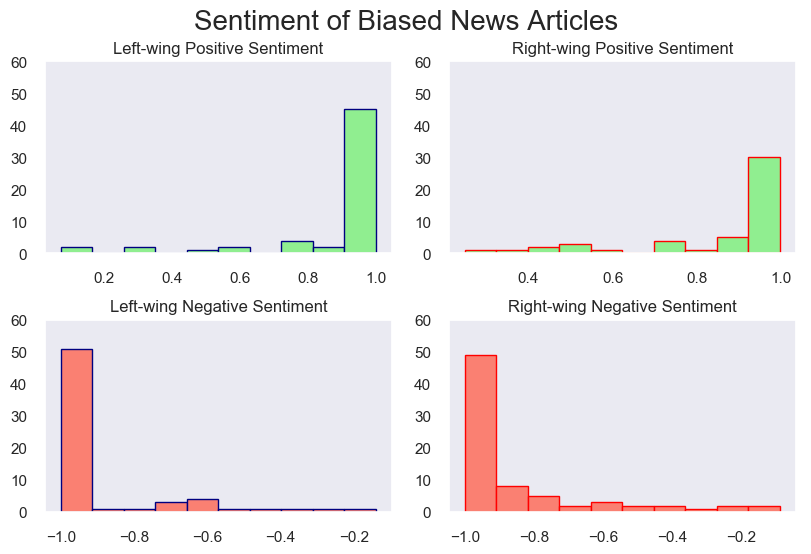

In [718]:
#plot subplots of histograms

plt.rcParams['figure.dpi'] = 100
fig, axs = plt.subplots(2, 2, constrained_layout=True)
axs[0, 0].hist(lw_pos.Compound, color = "lightgreen", ec= "navy")
axs[0, 0].set_title('Left-wing Positive Sentiment')
axs[0, 0].set(ylim=[0, 60])
axs[0, 0].grid(False)

axs[0, 1].hist(rw_pos.Compound, color = "lightgreen", ec= "red")
axs[0, 1].set_title('Right-wing Positive Sentiment')
axs[0, 1].set(ylim=[0, 60])
axs[0, 1].grid(False)

axs[1, 0].hist(lw_neg.Compound, color = "salmon", ec= "navy")
axs[1, 0].set_title('Left-wing Negative Sentiment')
axs[1, 0].set(ylim=[0, 60])
axs[1, 0].grid(False)

axs[1, 1].hist(rw_neg.Compound, color = "salmon", ec= "red")
axs[1, 1].set_title('Right-wing Negative Sentiment')
axs[1, 1].set(ylim=[0, 60])
axs[1, 1].grid(False)
plt.suptitle('Sentiment of Biased News Articles',fontsize=20)


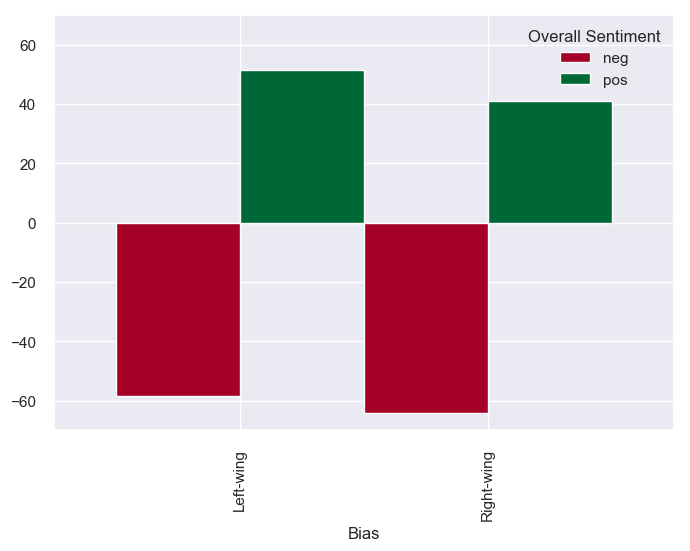

In [765]:
#build plot of pos and neg sentiment between RW and LW media
seaborn.set()
total_sent = data.groupby(['Bias','Overall Sentiment']).sum().unstack()
total_sent.columns = total_sent.columns.droplevel()


total_sent.plot(kind = 'bar', colormap = cm.RdYlGn, width = 1,ylim=[-70, 70])
plt.show()

Sentiment of input text

In [747]:
#create function to determine sentiment

def sentiment(input):
    input = input.lower()

    sentiment = sid.polarity_scores(input)['compound']
    return(sentiment)

In [759]:
#create analyse function to combine bias and sentiment

def analyse(input):
    #run sentiment function
    input_sentiment = sentiment(input)
    #group into pos and neg
    if input_sentiment >= 0:
        overall_sentiment = "positive"
    else:
        overall_sentiment = "negative"
    #run bias function    
    input_bias = bias(input)
    
    #return string of analysis
    analysis = f"This article has a {input_bias} bias and a {overall_sentiment} sentiment, with a sentiment score of {input_sentiment}."
    return(analysis)

In [773]:
analyse("Joe Biden Hates America and is a communist")

'This article has a Right-wing bias and a negative sentiment, with a sentiment score of -0.4404.'

In [775]:
analyse("Joe Biden loves America")

'This article has a Left-wing bias and a positive sentiment, with a sentiment score of 0.5719.'

In [797]:
analyse("Trump is a racist")

'This article has a Left-wing bias and a negative sentiment, with a sentiment score of -0.6124.'

In [777]:
#enter input text
input_text = str(input("input text: "))

input text: If you ask President Donald Trump, he isn’t racist. To the contrary, he’s repeatedly said that he’s “the least racist person that you’ve ever encountered.” Trump’s actual record, however, tells a very different story. On the campaign trail, Trump repeatedly made explicitly racist and otherwise bigoted remarks, from calling Mexican immigrants criminals and rapists, to proposing a ban on all Muslims entering the US, to suggesting a judge should recuse himself from a case solely because of the judge’s Mexican heritage. The trend has continued into his presidency. From stereotyping a Black reporter to pandering to white supremacists after they held a violent rally in Charlottesville, Virginia, to making a joke about the Trail of Tears, Trump hasn’t stopped with racist acts after his 2016 election. Most recently, Trump has called the SARS-CoV-2 coronavirus the “Chinese virus” and “kung flu” — racist terms that tap into the kind of xenophobia that he latched onto during his 2016 

In [778]:
analyse(input_text)

'This article has a Left-wing bias and a negative sentiment, with a sentiment score of -0.989.'

In [780]:
#enter input text
input_text = str(input("input text: "))

input text: This is America’s day.  This is democracy’s day.  A day of history and hope.  Of renewal and resolve.  Through a crucible for the ages America has been tested anew and America has risen to the challenge.  Today, we celebrate the triumph not of a candidate, but of a cause, the cause of democracy.  The will of the people has been heard and the will of the people has been heeded.  We have learned again that democracy is precious.  Democracy is fragile.  And at this hour, my friends, democracy has prevailed.  So now, on this hallowed ground where just days ago violence sought to shake this Capitol’s very foundation, we come together as one nation, under God, indivisible, to carry out the peaceful transfer of power as we have for more than two centuries.  We look ahead in our uniquely American way – restless, bold, optimistic – and set our sights on the nation we know we can be and we must be.  I thank my predecessors of both parties for their presence here.  I thank them from t

In [783]:
analyse(input_text)

'This article has a Left-wing bias and a positive sentiment, with a sentiment score of 0.993.'

In [804]:
#enter input text
input_text = str(input("input text: "))

input text:  Republican Sen. Tim Scott (S.C.) introduced new legislation Wednesday calling for the establishment of an "election integrity commission" that will both examine claims of election fraud and plan ways to bolster the integrity of future elections. Scott's bill would establish what he calls the "2020 Bipartisan Advisory Committee," consisting of nine lawmakers chosen by Republicans and nine lawmakers chosen by Democrats. The committee would investigate how the coronavirus pandemic impacted the election, and specifically the election practices like widespread mail-in voting, adopted because of the pandemic. Committee members would also investigate methods of voter fraud, the scope of voter fraud, and how to improve the election system to mitigate voter fraud. After conducting an investigation, the committee would publish two reports: one report on precinct-by-precinct instances of voter fraud, including fraudulent registration, and another on how to stop voter fraud, especiall

In [805]:
analyse(input_text)

'This article has a Right-wing bias and a negative sentiment, with a sentiment score of -0.9618.'

In [806]:
analyse("Donald Trump is a racist")

'This article has a Left-wing bias and a negative sentiment, with a sentiment score of -0.6124.'

In [808]:
analyse("Donald Trump is an amazing president")

'This article has a Left-wing bias and a positive sentiment, with a sentiment score of 0.5859.'

In [809]:
analyse("Joe Biden is a racist")

'This article has a Right-wing bias and a negative sentiment, with a sentiment score of -0.6124.'

In [811]:
analyse("Joe Biden is an amazing president")

'This article has a Right-wing bias and a positive sentiment, with a sentiment score of 0.5859.'